# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

In [1]:
!pip install gseapy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import gseapy as gp

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from scipy.stats import beta

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

Similarly to Week 9 exercises, we first describe a system in which a (nuclear) pre-mRNA is transcribed and spliced to produce an mRNA. We can write a 2D ODE (ignoring the degradation of the pre-mRNA):

\begin{eqnarray*}
&&\frac{dP}{dt} = s(t) - \rho P \\
&&\frac{dM}{dt} = \rho P - k(t) M \\
\end{eqnarray*}

Here, $P$ and $M$ denote, respectively, the concentrations of pre-mRNA and mRNA. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is $\omega=\frac{2\pi}{T}$ with $T=24h$. $s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that here the peak of $s(t)$ is at $t=0$. 
Similarly, we will consider $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ is the splicing rate of pre-mRNA $P$ to mRNA $M$, and is also taken as a constant.

### Question 1
1. Adapt the code of week 9 exercises to simulate this new system. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.

**Answer: see cell "Simulation of the system".**

2. Keep the degradation rate constant ($\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$. Discuss on how 1) the phase delay between $M(t)$ and $P(t)$ and 2) the relative amplitude of $M(t)$ varies in function of $k_0$. What is the maximal relative amplitude? Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).

**Answer: 
(1) At first, we could observe that the phase delay of $M(t)$ in respect to $P(t)$ does not seem to be impacted by the variation of $k_0$. When $k_0$ increases, both are in sync. However, when $k_0$ tends to 0, the phase of $M(t)$ is delayed of a couple hundreds of minute (based on our time axis) relative to $P(t)$. (2) The relative amplitude of $M(t)$ is inversely proportional to the value of $k_0$, i.e. as $k_0$ decreases, the relative amplitude of $M(t)$ increases.**

3. Vary $\epsilon_k$ to include rhythmic degradation. Discuss the different effects, in particular, find situations that extend beyond what is possible with a constant half-life. See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

**Answer: 
As $\epsilon_k$ increases, the sinusoidal behavior of $M(t)$ is lost, and its relative amplitude decreases, up to a constant level, which would be impossible with a constant degradation rate. When $\epsilon_k$ becomes superior than $\epsilon_s$, $M(t)$ shifts, and $P(t)$ and $M(t)$ are out of phase. Since the degradation rate is also ryhtmic, the relative amplitude of mRNA abundance is either damped or magnified, based on $\epsilon_k$**

#### Answer: Simulation of the system

In [3]:
def s(t, s0, e_S, rythmic = True):
    #Transcription rate function.
    #Input:
    #.     - t: time
    #.     - s0: transcription rate constant
    #.     - e_S: the relative amplitude
    #.     - rythmic: a boolean that determines if the transcription rate is rythmic or not.
    #.                (True by default)   
    w = 2*np.pi/(24*60)
    if rythmic == True:   
        return s0 * (1 + e_S*np.cos(w*t))
    else:
        return s0

def k(t, k0, e_K, tk, rythmic = True):
    #Degradation rate function.
    #Input:
    #.     - t: time
    #.     - k0: degradation rate constant
    #.     - e_K: the relative amplitude
    #.     - tk: time at which the degradation is maximal
    #.     - rythmic: a boolean that determines if the transcription rate is rythmic or not.
    #.                (True by default) 
    w = 2*np.pi/(24*60)
    if rythmic == True:
        return k0 * (1 + e_K*np.cos(w*(t-tk)))
    else:
        return k0

def func(y, t, s0, k0, e_S, e_K, tk, rho):
        #Degradation rate function.
    #Input:
    #.     - t: time
    #.     - s0: transcription rate constant
    #.     - k0: degradation rate constant
    #.     - e_S: the relative amplitude of the transcription
    #.     - e_K: the relative amplitude of the degradation
    #.     - tk: time at which the degradation is maximal
    #.     - rho: the splicing rate
    P, M=y
    return [s(t, s0, e_S) - rho * P, rho * P - k(t, k0, e_K, tk) * M] 


def simulation(func, par, x0 = None, t = None):
    s0=par['s0']
    k0=par['k0']
    e_S=par['e_S']
    e_K=par['e_K']
    tk =par['tk']
    rho=par['rho']
    
    xx=odeint(func, x0, t, args=(s0, k0, e_S, e_K, tk, rho))
    plt.figure(1)
    plt.ylim([0,200])
    plt.plot(t, xx[:,0],label = 'P(t)')
    plt.plot(t, xx[:,1],label = 'M(t)')
    plt.xlabel("time [min]")
    plt.ylabel("#molecules")
    plt.legend()
    plt.show()
    
def animate(x0, time, s0=5, k0= 0.05, e_S=0.0, e_K=0.0 , tk = 10, rho=0.2):
    #define the function domain
    par={'s0':s0,'k0':k0, 'e_S':e_S, 'e_K':e_K, 'tk':tk, 'rho':rho}
    simulation(func, par, x0, time)

#initial conditions
z0=[0,0] #[P, M]
t = np.linspace(0,10000,10001)
interact(animate, x0=fixed(z0), time=fixed(t), 
         s0 = (1,10,0.01),
         k0 = (1/120,1/10,0.01),
         e_S = (0,1,1/100),
         e_K = (0,1,1/100),
         rho = (1/30,1,0.05));

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0, step=0.01), FloatSlider(valu…

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

We will now analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12h-12h light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Adapt code from week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes): ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``
`First start with only the exons, then only the introns, and eventually both. Describe your observations.

**Answer:
PC1 correlates with the feature, i.e. intron or exon, and describes most of the variance observed (67.3%). For exons and introns, we get that PC1-PC2 considering the time and the replicates yields a circular pattern. This can be interpreted as a 24h cycle for both features. With PC3, we see that the replicates show little variation inbetween them, hence the experimental noise is negligeable. When taking intronic and exonic reads together, PCA allows for distinction of the two features, and again illustrates the rythmical behavior of both. Also, exonic reads correlate with polysomal RNA (RFP).** 

2. Using the *return_amp_phase_pv* function with the $log_2$ data, assess rhythmicity genome-wide (use the p-value to make gene selections). For the selected genes, provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough). Do this separately for the exons and introns. Do you see what's commonly referred to as the morning and evening waves of genes expression?

**Answer: For exons, we see a wave between ZT5 and ZT15 (morning wave), and between ZT16 and ZT3 (evening wave). The same observations can be described for introns, although the exons wave is somewhat delayed relative to introns. This matches the fact that mRNA is a product of pre-mRNA after modifications (e.g. splicing).**

3. Which genes are overall the most robustly rhythmic? Is there a theme?

**Answer: When looking at the list of selected genes on the basis of their p-value (the lowest the p-value, the more significant the gene is, the more robustly rhythmic it is), we notice that many of the 14 genes we worked with so far are present towards the top of the list. These genes are either core clock or clock output genes.**

4. Adapting the enrichR code from Week 9 exercises, find biological function or transcriptional programs regulated rhythmically in the mouse liver. Do this separately for the night and the day. Comment.

**Answer: Using genes that were selected for showing evidence of a robust rythmicity, we find biological functions enriched in day-induced or night-induced genes. First, looking at genes that are day-induced, we find a significant enrichment for functions related to metobolic regulation (such as cholesterol homeostasis or glycogen biosynthesis) as well as exercise-induced circadian regulation. On the other hand, night-induced genes are enriched in functions related to negative regulation of glucocorticoid receptors.**

#### Load the RNA-seq data

In [4]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

dat.head()

condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Gnai3       -1.564402 -1.536626 -1.931707 -1.458354 -1.575970 -1.654038   
Cdc45       -3.838233 -4.132913 -4.023130 -3.782926 -3.971205 -3.898270   
Apoh        -1.075680 -1.540220 -1.569142 -1.652602 -1.786800 -1.539642   
Narf        -1.198793 -0.937221 -0.921084 -0.331866 -0.123671 -0.186613   
Cav2        -3.046334 -3.741371 -3.364087 -3.063080 -3.374724 -2.992739   

condition                                            ...             \
feeding                                              ...              
feature                                              ...        RFP   
time               12        14        16        18  ...         04   
replicate           A         A         A         A  ...          D   
Gene_Symbol                                          ...              
Gnai3       -1.550707 -1.564596 -1.211372 -1.654187  ...   4.739938   
Cdc45       -3.837377 -3.907227 -4.002231 -3.837719  ...  -1.783427   
Apoh        -1.434320 -1.655522 -1.499171 -1.411709  ...  10.657651   
Narf        -0.632810 -0.963087 -0.999763 -1.320254  ...   1.788997   
Cav2        -2.985271 -2.991166 -2.954387 -3.052015  ...   0.759856   

condition                                                                      \
feeding                                                                         
feature                                                                         
time                06         08         10         12         14         16   
replicate            D          D          D          D          D          D   
Gene_Symbol                                                                     
Gnai3         4.648414   4.576937   4.891934   5.284247   5.502545   5.115915   
Cdc45        -1.045727  -1.868940  -1.616297   1.552717   0.336330  -1.370050   
Apoh         10.460193  10.623698  10.381588  10.146668  10.232355  10.631922   
Narf          2.660656   2.890531   3.379632   2.924193   2.472548   2.686118   
Cav2          0.403964   0.581452   0.716145   0.742948   0.385111   0.282426   

condition                                     
feeding                                       
feature                                       
time                18         20         22  
replicate            D          D          D  
Gene_Symbol                                   
Gnai3         5.402904   5.119890   4.873039  
Cdc45        -0.308212  -1.218384  -0.541827  
Apoh         10.468625  10.704931  10.591210  
Narf          2.390108   1.941836   2.128767  
Cav2          0.624375   0.806800   0.524357  

[5 rows x 144 columns]

#### Question1 (1): PCA

In [5]:
# filter for only these genes like the instruction says
genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
dat2 = dat[dat.index.isin(genes)]
dat2

condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Cry1        -3.015745 -2.888921 -3.226192 -3.355850 -3.444067 -2.907677   
Nr1d1       -3.736364  0.629202  1.124620  2.043870  0.982958  0.511537   
Per1        -3.628741 -2.709595 -3.435573 -2.387584 -1.056242 -0.152236   
Nr1d2       -2.381752 -0.994712 -0.407671  0.606150  0.358367  0.340322   
Tef         -1.868908 -0.891298  0.191412  1.471059  1.801677  1.936604   
Npas2       -1.962732 -2.192843 -3.944118 -4.209720 -4.256702 -4.273067   
Rorc        -1.253206 -1.378898 -1.536282 -0.618622 -0.467160  0.278091   
Per3        -3.495905 -3.181697 -2.035363 -0.022370 -0.187357  0.141948   
Clock       -1.597633 -1.549136 -1.794397 -1.740208 -2.561197 -2.653104   
Rora        -2.693287 -2.700310 -2.593670 -2.170328 -2.909943 -2.726880   
Arntl       -1.669041 -1.694083 -2.706959 -3.508204 -3.848818 -4.003520   
Per2        -3.124204 -3.159253 -2.878459 -1.982470 -1.676214 -1.620635   
Dbp         -4.008243 -2.292534  0.462570  2.588438  2.665088  2.456974   
Cry2        -2.125658 -1.418011 -1.267150 -0.570111 -0.933872 -0.568488   

condition                                            ...                      \
feeding                                              ...                       
feature                                              ...       RFP             
time               12        14        16        18  ...        04        06   
replicate           A         A         A         A  ...         D         D   
Gene_Symbol                                          ...                       
Cry1        -2.312536 -1.554579 -1.367280 -1.529984  ...  1.572807  1.120746   
Nr1d1       -1.230222 -0.741516 -1.790100 -3.172459  ...  4.588014  6.154936   
Per1        -0.438939 -0.509765 -0.121126 -1.009331  ... -2.138933 -0.200017   
Nr1d2       -0.094746 -0.396083 -0.858595 -1.169440  ...  1.708285  3.135121   
Tef          1.283871  1.021040  0.917403  0.640625  ...  1.007415  2.801583   
Npas2       -4.269427 -4.246326 -4.237317 -4.149953  ... -0.111984 -3.286106   
Rorc         0.713569  0.547221  1.120359  0.965740  ...  2.894547  2.889117   
Per3        -0.063494 -0.708187 -0.622593 -0.908967  ... -2.686956 -0.683712   
Clock       -2.276997 -2.292100 -1.115022 -1.490327  ...  1.518437  1.848053   
Rora        -2.328619 -2.963493 -2.510860 -2.949647  ...  2.293165  2.382298   
Arntl       -3.509194 -2.494314 -2.238684 -2.282043  ...  3.022983  1.673178   
Per2        -0.877580 -0.834560 -0.323326 -1.117581  ... -1.610890 -0.370055   
Dbp          1.041185  0.318019 -1.223801 -0.982887  ...  1.702946  6.467692   
Cry2        -0.830493 -0.808692 -0.764942 -0.753802  ...  2.403922  3.050125   

condition                                                                \
feeding                                                                   
feature                                                                   
time               08        10        12        14        16        18   
replicate           D         D         D         D         D         D   
Gene_Symbol                                                               
Cry1         0.413170  1.039117  1.978841  2.477187  0.829508  2.543046   
Nr1d1        6.083459  5.261807  3.157981  2.257294  5.733012  3.179474   
Per1         1.814241  2.825217  3.149151  2.353000  0.024632 -1.356326   
Nr1d2        3.397667  3.620700  2.844902  2.293430  2.981029  0.880329   
Tef          3.826824  4.267694  3.922466  3.852229  3.221980  1.217154   
Npas2       -3.129760 -3.995698 -4.009316 -4.020822 -3.073643 -0.001143  

In [6]:
## Subselect samples of the full data based on feature, condition, replicate and time
def subselect(data, feature, time, replicate):
    f1 = data.columns.get_level_values('feature').isin(feature)
    f2 = data.columns.get_level_values('time').isin(time)
    f3 = data.columns.get_level_values('replicate').isin(replicate)
    dat_sub= data.iloc[:,f1 & f2 & f3]
    
    return dat_sub

## Plot PCA for a data.frame and display color/shape according to the input parameter
def run_PCA(data, nc=5, x_1=1, x_2=2, col='replicate', shape='time', scale_d=True, log=False):
    pca = PCA(n_components=nc)
    x_1=x_1-1
    x_2=x_2-1
    if(scale_d):
        data_2 = scale(data)
    else:
        data_2 = data
        
    if(log):
        data_2 =  np.log2(data_2 + 1)
        
    pca.fit(data_2.T)

    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    
    ## compute PCA and plot
    pca_transformed = pca.transform(data_2.T)
    fig = px.scatter(pca_transformed, x=x_1, y=x_2, 
                     color=data.columns.get_level_values(col), 
                     symbol=data.columns.get_level_values(shape),
                     width=600, height=600)
   
    fig.update_traces(marker={'size': 13})
    fig.update_layout(plot_bgcolor = 'rgb(243,243,243)', xaxis_title=labels[str(x_1)],
                      yaxis_title=labels[str(x_2)])
    fig.show()
    
    df_pca= pd.DataFrame(pca.components_, columns=data.index, index = ['PC-1','PC-2','PC-3','PC-4','PC-5']);

    return df_pca

In [84]:
## Subselect for either introns or exons
time = ['00','02','04','06','08','10','12','14','16','18','20','22']

dat_intron = subselect(dat2,['Intron'],time, ['A','B','C','D'])
dat_exon = subselect(dat2, ['Exon'],time, ['A','B','C','D'])

condition          WT                                                    \
feeding            AL                                                     
feature          Exon                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Cry1         3.572328  2.437415  1.226081  0.982076  1.097388  1.467306   
Nr1d1       -1.369237  2.128130  3.447507  4.409804  3.420381  3.063771   
Per1        -1.593263 -0.838934 -2.236218 -0.499682  1.193454  1.913019   
Nr1d2        0.974689  2.073089  3.482730  4.372417  4.738310  4.886418   
Tef          2.125702  1.558489  2.901476  4.088388  4.790640  5.075526   
Npas2        0.891954  0.673039 -0.896812 -2.611035 -3.255635 -3.628434   
Rorc         5.023959  3.990191  3.492274  3.459373  3.784086  4.075536   
Per3        -1.387251 -2.091173 -0.835314  1.105665  1.849448  2.104162   
Clock        3.183875  3.488150  3.142962  3.301125  2.634239  2.394336   
Rora         3.140386  3.373177  2.904770  3.057440  3.243302  3.172471   
Arntl        3.692636  3.505191  2.972445  0.972102 -0.913067 -1.070822   
Per2         0.702243  1.086441  0.407997  0.517667  2.154221  2.289250   
Dbp         -0.851537 -1.003540  2.018128  4.388734  5.005398  5.472079   
Cry2         1.365035  1.504562  1.619315  1.945948  2.362679  2.369434   

condition                                            ...                      \
feeding                                              ...                       
feature                                              ...                       
time               12        14        16        18  ...        04        06   
replicate           A         A         A         A  ...         D         D   
Gene_Symbol                                          ...                       
Cry1         2.044564  3.338576  3.286489  3.434700  ...  2.383538  1.262110   
Nr1d1        1.345997  1.578873  0.199511 -0.618280  ...  2.734802  4.041276   
Per1         1.541785  2.340001  1.802619  0.875075  ... -2.767682 -0.630709   
Nr1d2        4.100144  3.503233  3.902687  3.751726  ...  3.131537  4.240677   
Tef          4.749874  4.545244  4.165551  3.991828  ...  2.477557  4.001942   
Npas2       -3.386072 -3.742119 -3.887134 -4.022835  ... -0.039872 -2.796511   
Rorc         4.662547  5.221632  5.197643  5.305360  ...  3.704683  3.441347   
Per3         2.118474  1.236035  1.974312  1.295675  ... -2.000704  1.174870   
Clock        1.711894  1.941243  3.016355  3.280087  ...  3.425471  3.283892   
Rora         2.707634  2.486577  3.205594  3.055862  ...  3.122186  3.046529   
Arntl       -0.268762  0.981804  2.049311  2.624204  ...  3.403524  1.355379   
Per2         3.062755  3.373231  3.022434  3.141148  ... -0.531633  0.707305   
Dbp          4.266733  3.097448  2.430786  1.694252  ...  0.268008  4.451284   
Cry2         2.196795  2.311935  1.932489  2.009034  ...  1.703633  2.039546   

condition                                                                \
feeding                                                                   
feature                                                                   
time               08        10        12        14        16        18   
replicate           D         D         D         D         D         D   
Gene_Symbol                                                               
Cry1         0.962847  1.602069  2.845668  3.187133  2.848477  3.309036   
Nr1d1        4.194639  3.232297  1.330865 -0.022566 -0.427273 -1.728005   
Per1         0.837022  1.858786  2.082392  0.865368  0.599184  0.581171   
Nr1d2        4.654605  4.734653  4.103033  3.639740  3.819029  2.834469   
Tef          4.789763  4.945746  4.683031  4.500160  4.235039  3.889863   
Npas2       -3.414193 -3.861132 -4.020141 -4.009517 -3.523579 -3.496727  

------EXON-------


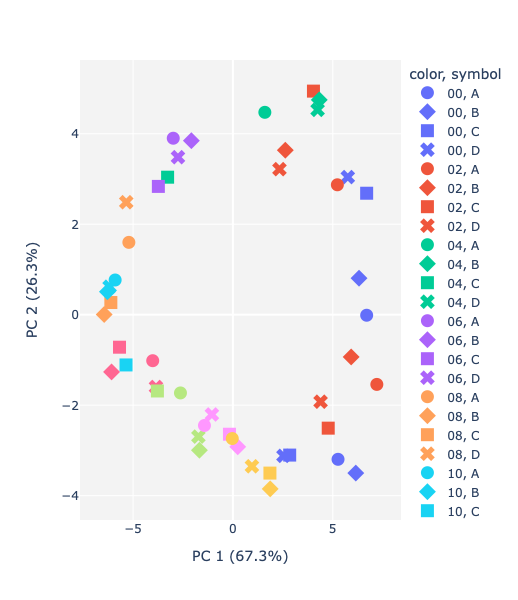

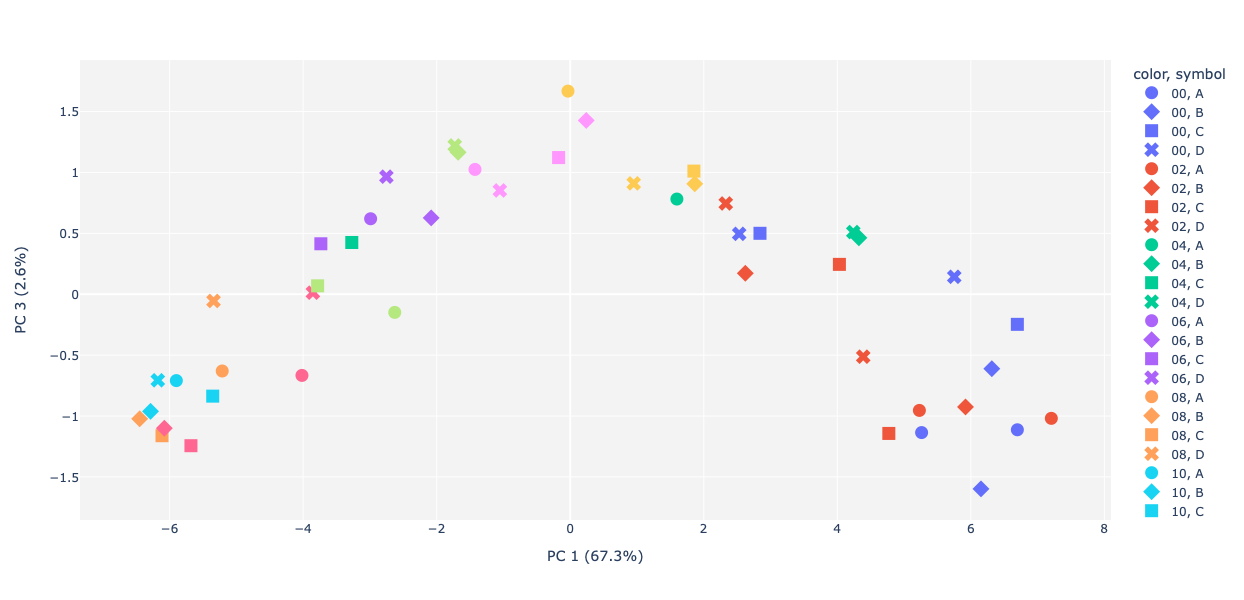

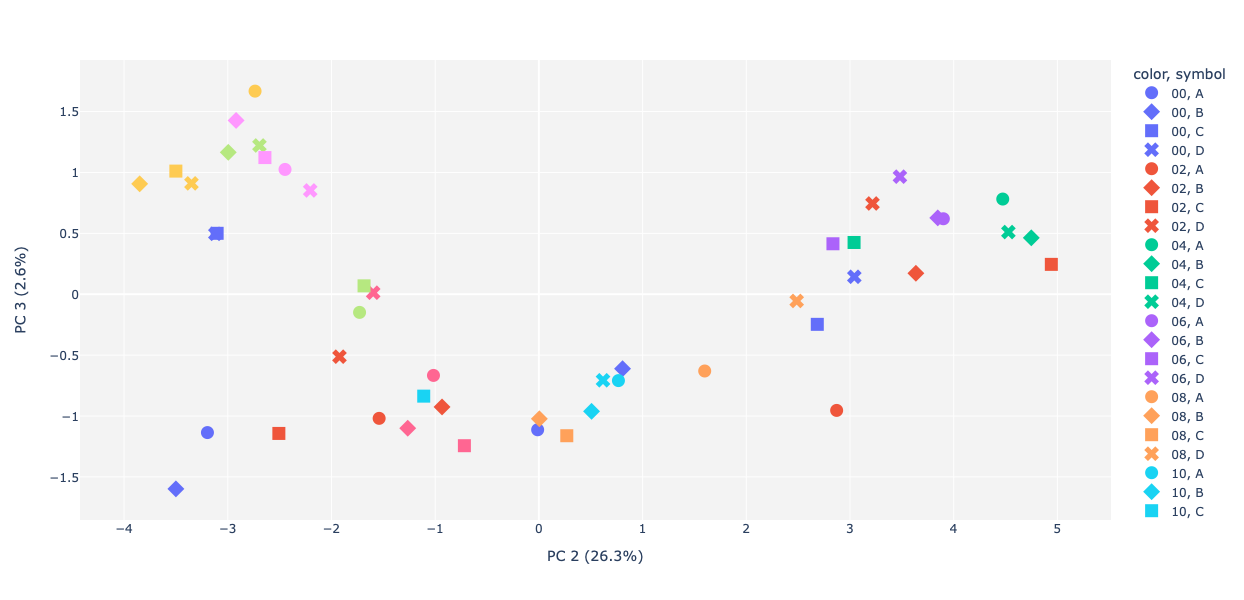

In [25]:
print("------EXON-------")
run_PCA(dat_exon, x_1=1, x_2=2, col='time', shape='replicate', scale_d=False, log=False);
run_PCA(dat_exon, x_1=1, x_2=3, col='time', shape='replicate', scale_d=False, log=False);
run_PCA(dat_exon, x_1=2, x_2=3, col='time', shape='replicate', scale_d=False, log=False);

------INTRON-------


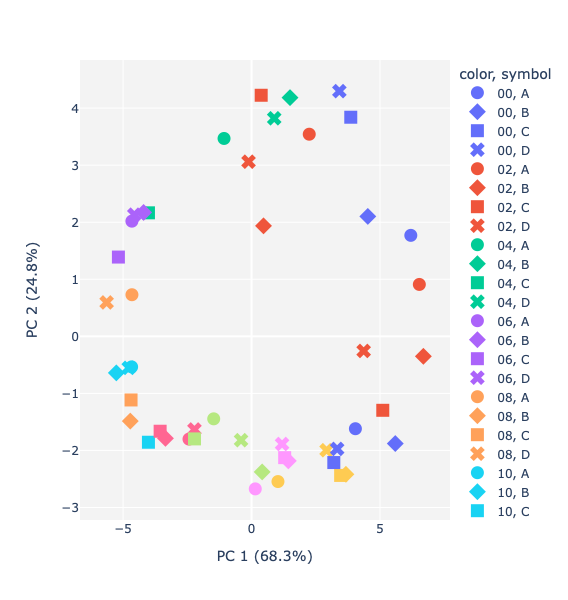

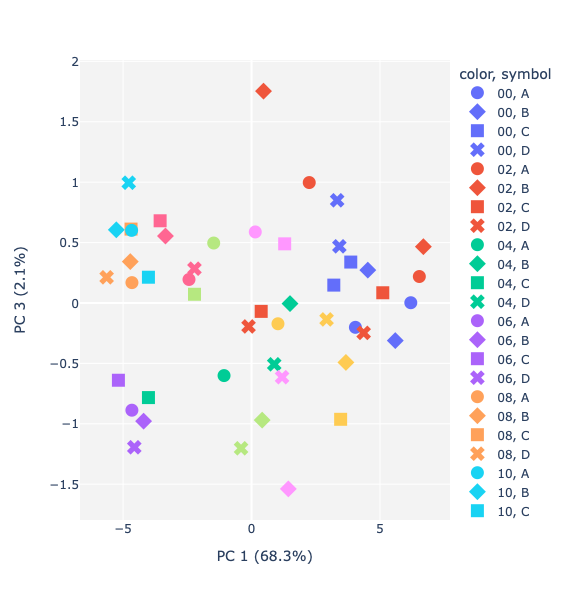

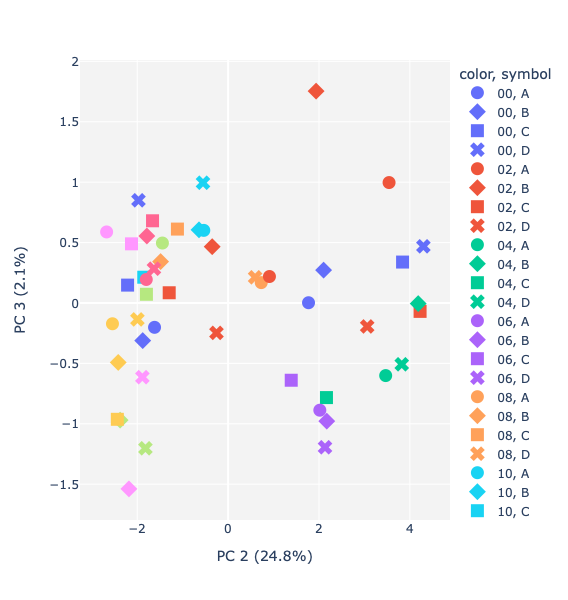

In [26]:
print("------INTRON-------")
run_PCA(dat_intron, x_1=1, x_2=2, col='time', shape='replicate', scale_d=False, log=False);
run_PCA(dat_intron, x_1=1, x_2=3, col='time', shape='replicate', scale_d=False, log=False);
run_PCA(dat_intron, x_1=2, x_2=3, col='time', shape='replicate', scale_d=False, log=False);

------BOTH-------


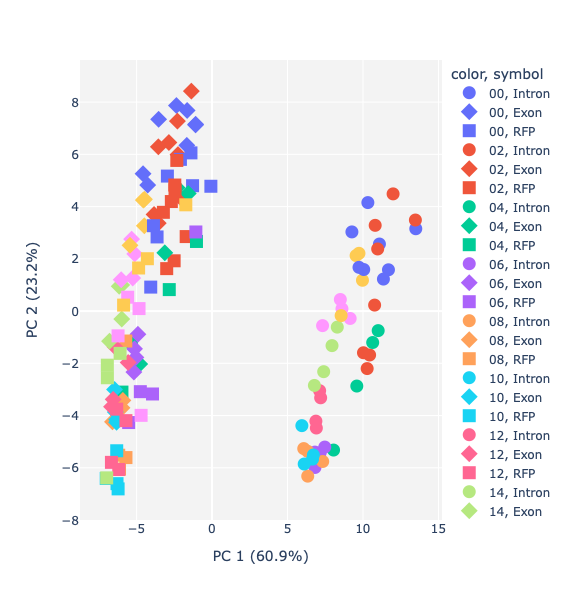

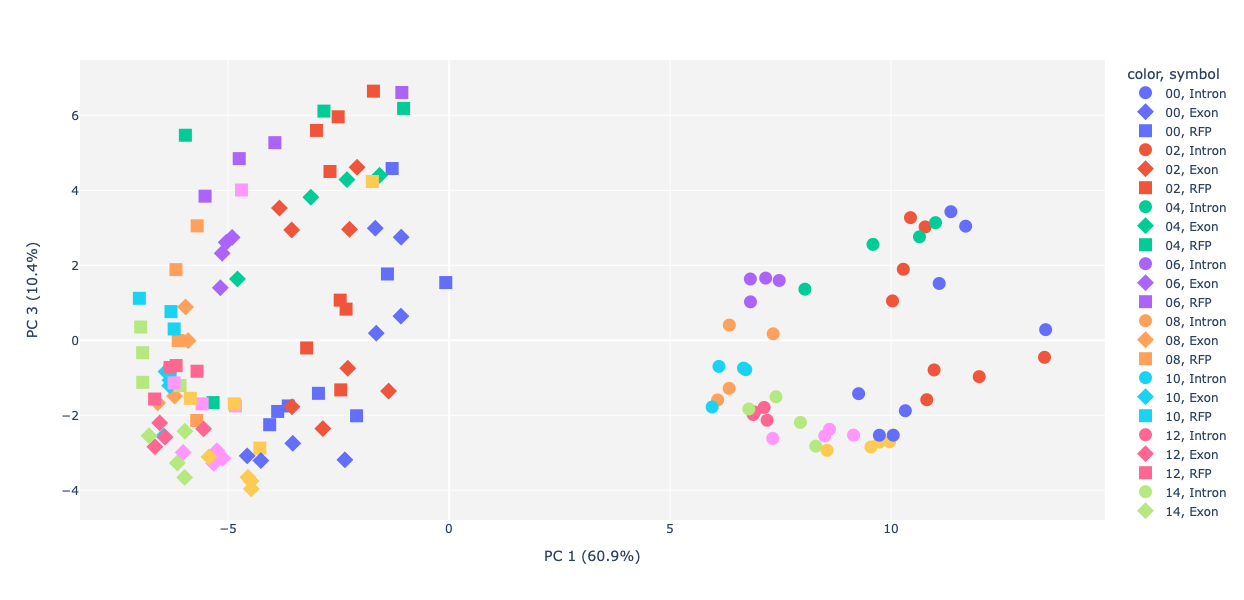

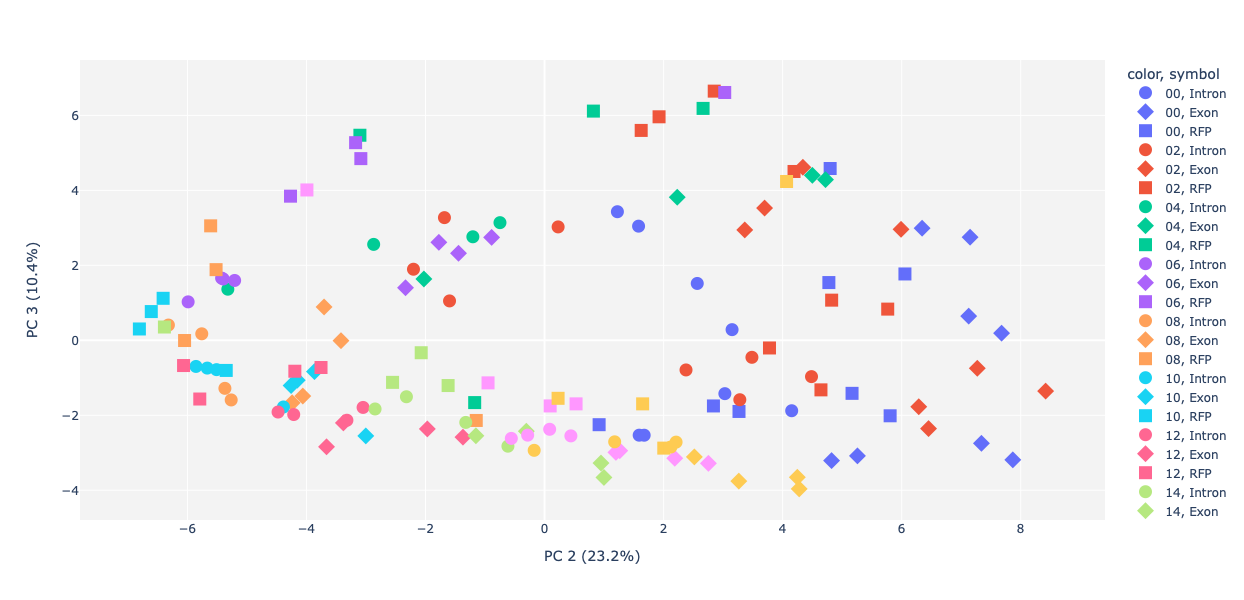

In [30]:
print("------BOTH-------")
run_PCA(dat2, x_1=1, x_2=2, col='time', shape='feature', scale_d=False, log=False);
run_PCA(dat2, x_1=1, x_2=3, col='time', shape='feature', scale_d=False, log=False);
run_PCA(dat2, x_1=2, x_2=3, col='time', shape='feature', scale_d=False, log=False);

#### Question1 (2): Rythmicity assertion

In [6]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    
    # we do the harmonic regression using a Fourier series
    t = np.linspace(0.0, N * Ts, N)
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)
    mu = 1 / N * x_fft[0].real
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval= 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [7]:
#Apply the function for all the genes at the intron or exon level and retrieve the amplitude, phase, mean and p-value.

Ts = 2.0 # sampling time 
T = 24 # period
N = 48 # number of samples

amp_intron = []
phase_intron = [] 
pv_intron = []
mu_intron = []

i_pos = dat.columns.get_level_values('feature').isin(['Intron'])

for i, row in dat.iterrows():
    [a, p, pv, mu] = return_amp_phase_pv(np.array(row)[i_pos], Ts, T, N)
    amp_intron.append(a)
    phase_intron.append(p)
    pv_intron.append(pv)
    mu_intron.append(mu)
    
amp_exon = []
phase_exon = [] 
pv_exon = []
mu_exon = []

e_pos = dat.columns.get_level_values('feature').isin(['Exon'])

for i, row in dat.iterrows():
    [a, p, pv, mu]=return_amp_phase_pv(np.array(row)[e_pos], Ts, T, N)
    amp_exon.append(a)
    phase_exon.append(p)
    pv_exon.append(pv)
    mu_exon.append(mu)

#convert the lists to numpy arrays
phase_intron=np.array(phase_intron)
amp_intron=np.array(amp_intron)
pv_intron=np.array(pv_intron)
mu_intron=np.array(mu_intron)

phase_exon=np.array(phase_exon)
amp_exon=np.array(amp_exon)
pv_exon=np.array(pv_exon)
mu_exon=np.array(mu_exon)

In [8]:
## Keep genes with significant p value, e.g. p < 0.001
val = np.array([phase_exon, amp_exon, pv_exon, mu_exon, phase_intron, amp_intron, pv_intron, mu_intron])
ind = np.array(['phase_exon', 'amp_exon', 'pv_exon', 'mu_exon', 'phase_intron', 'amp_intron', 'pv_intron', 'mu_intron'])
df = pd.DataFrame(val, ind, columns = dat.index).T

#selected genes: 
df = df.loc[(df['pv_exon'] < 0.001) & (df['pv_intron'] < 0.001)]
df

,phase_exon,amp_exon,pv_exon,mu_exon,phase_intron,amp_intron,pv_intron,mu_intron
Gene_Symbol,,,,,,,,
Narf,10.049716,1.194847,2.605693e-13,3.335644,8.569998,1.340003,6.206147e-13,-0.906355
Gna12,8.819359,0.685685,3.576385e-09,4.857602,6.628445,0.922182,3.988533e-06,-1.053318
Sdhd,13.274476,0.207097,2.969034e-04,6.901632,10.959231,0.437833,2.685550e-04,0.142123
Tpd52l1,10.946979,0.693384,5.454002e-09,1.906146,3.956429,0.251385,6.878809e-04,-3.586699
Cdh1,23.948997,0.766640,8.190278e-09,3.785725,19.985429,0.581230,7.647059e-04,-2.411397
...,...,...,...,...,...,...,...,...
Gm5549,22.841451,1.052243,1.243973e-04,1.081142,20.246489,0.721456,1.109896e-04,-3.369496
Tnnc1,16.302675,2.851966,1.543210e-14,-0.355156,14.961674,2.560754,7.123524e-12,-2.777369
Hmgcs1,0.555830,1.253505,1.864567e-04,6.770997,22.272463,1.844885,3.389509e-06,0.551205


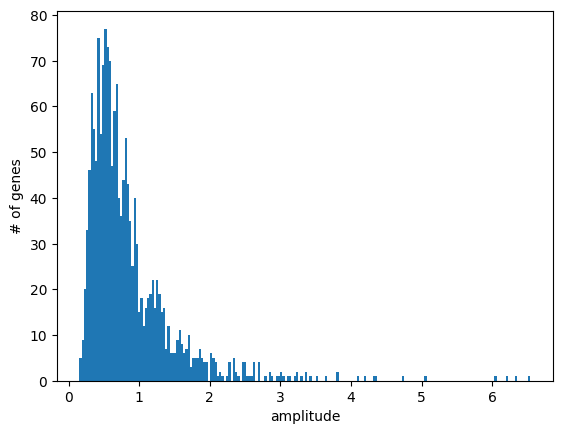

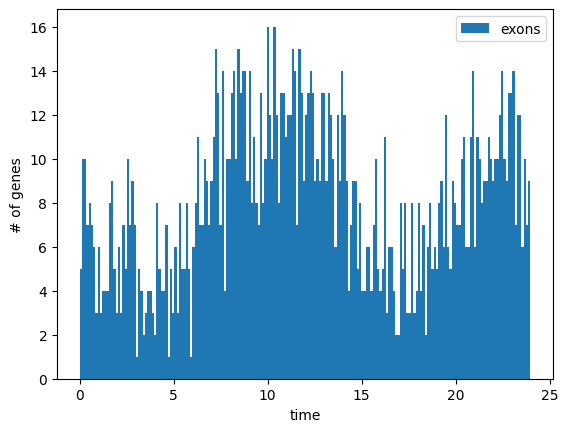

In [9]:
#Peak times and amplitudes for exons
plt.subplot(1, 1, 1)
plt.hist(df['amp_exon'], bins=200, label = 'exons')
plt.xlabel("amplitude")
plt.ylabel("# of genes")
plt.show()

plt.subplot(1, 1, 1)
plt.hist(df['phase_exon'], bins=200, label = 'exons')
plt.xlabel("time")
plt.ylabel("# of genes")

plt.legend()

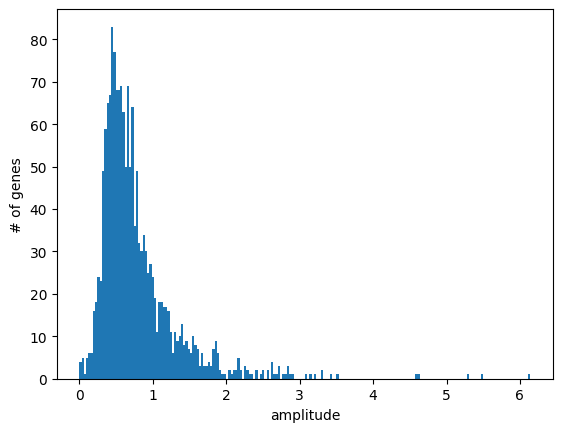

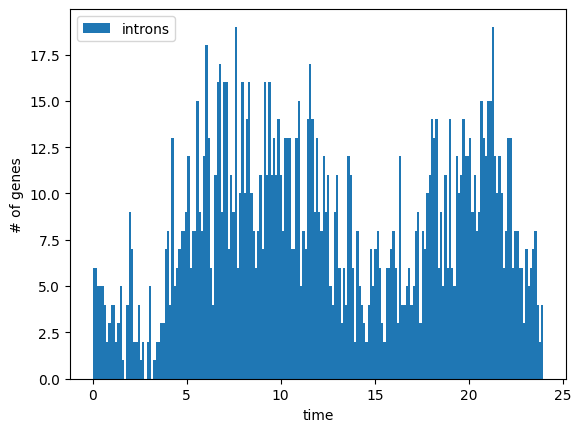

In [10]:
#Peak times and amplitudes for introns
plt.subplot(1, 1, 1)
plt.hist(df['amp_intron'], bins=200, label = 'introns')
plt.xlabel("amplitude")
plt.ylabel("# of genes")
plt.show()

plt.subplot(1, 1, 1)
plt.hist(df['phase_intron'], bins=200, label = 'introns')
plt.xlabel("time")
plt.ylabel("# of genes")

plt.legend()

#### Question1 (3): Rythmicity selection

In [11]:
## Subselect genes with lowest p_value, i.e. the most robustly rhythmic
gene_rhy = df.sort_values(by=['pv_exon', 'pv_intron'], ascending = True)

## Keep several hundred genes  
gene_rhy = gene_rhy.head(200)
gene_rhy

,phase_exon,amp_exon,pv_exon,mu_exon,phase_intron,amp_intron,pv_intron,mu_intron
Gene_Symbol,,,,,,,,
Nr1d1,7.066686,6.053347,0.000000e+00,0.991471,6.803025,5.307494,3.330669e-16,-1.065502
Mthfr,21.973991,2.339430,0.000000e+00,0.976560,20.827696,1.706204,2.331468e-15,-1.644979
Clpx,23.870682,2.380000,0.000000e+00,5.118455,21.058493,2.182240,4.107825e-15,0.110799
Cry1,19.198665,2.627418,0.000000e+00,2.569785,17.645336,2.117737,5.107026e-15,-2.338892
Zfp295,20.393435,1.549092,0.000000e+00,1.112235,20.026135,1.545722,4.426459e-13,-0.849044
...,...,...,...,...,...,...,...,...
Auh,9.612813,0.482020,5.164980e-12,1.590033,5.979490,0.528602,3.105857e-05,-2.534872
Fkbp5,13.680104,2.279845,5.524359e-12,2.386083,12.649445,1.581368,1.422203e-06,-2.381233
Ppara,10.570144,1.077683,5.706990e-12,5.092340,9.113892,1.373917,6.421880e-09,0.662934


#### Question1 (4): Biological investigation

In [12]:
day_gene = gene_rhy.loc[gene_rhy['phase_exon'].between(6, 16, inclusive=True) & gene_rhy['phase_intron'].between(6, 16, inclusive=True)] 
day_gene

/tmp/ipykernel_74/581328494.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  day_gene = gene_rhy.loc[gene_rhy['phase_exon'].between(6, 16, inclusive=True) & gene_rhy['phase_intron'].between(6, 16, inclusive=True)]


,phase_exon,amp_exon,pv_exon,mu_exon,phase_intron,amp_intron,pv_intron,mu_intron
Gene_Symbol,,,,,,,,
Nr1d1,7.066686,6.053347,0.000000e+00,0.991471,6.803025,5.307494,3.330669e-16,-1.065502
Dbp,10.154688,6.342534,1.110223e-16,2.224485,8.954931,6.142029,0.000000e+00,-0.404335
Camta1,11.930409,2.026367,1.110223e-16,0.076774,10.349570,0.658293,8.026912e-14,-3.550337
Abcg5,10.002306,1.858887,6.661338e-16,4.252237,7.443916,2.163318,6.877054e-12,-1.332353
Abcg8,8.438719,1.952905,2.331468e-15,3.746053,6.718197,1.902639,5.155809e-11,-1.706419
...,...,...,...,...,...,...,...,...
Actn1,10.026369,0.671496,4.833023e-12,3.086809,7.317982,0.641936,5.578005e-06,-2.328061
Timp3,13.707020,0.927011,4.984124e-12,2.129475,10.048541,0.740748,1.826369e-10,-3.156494
Ccne1,11.780155,2.343857,5.005774e-12,-0.973624,10.414751,0.953481,2.486902e-07,-3.597785


In [13]:
## Day genes: 
print("-----DAY GENES----")
enr = gp.enrichr(gene_list= day_gene.index.tolist(),
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list= day_gene.index.tolist(),
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

-----DAY GENES----


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cholesterol homeostasis (GO:0042632),5/71,0.000014,0.004142,0,0,18.336105,204.410320,ABCG8;ABCG5;DGAT2;NPC1;NR1D1
1,GO_Biological_Process_2021,sterol homeostasis (GO:0055092),5/72,0.000015,0.004142,0,0,18.061522,200.110905,ABCG8;ABCG5;DGAT2;NPC1;NR1D1
2,GO_Biological_Process_2021,glucan biosynthetic process (GO:0009250),3/13,0.000022,0.004142,0,0,71.082143,762.213804,GYS2;PER2;NR1D1
3,GO_Biological_Process_2021,glycogen biosynthetic process (GO:0005978),3/13,0.000022,0.004142,0,0,71.082143,762.213804,GYS2;PER2;NR1D1
4,GO_Biological_Process_2021,monocarboxylic acid metabolic process (GO:0032...,6/143,0.000038,0.005675,0,0,10.692620,108.903515,SLC5A6;PER2;CPT1A;NPC1;MTHFD1L;PPARA
5,GO_Biological_Process_2021,modified amino acid transport (GO:0072337),3/17,0.000052,0.006483,0,0,50.762755,501.002373,SLC5A6;SLC9A3R1;SLC16A12
6,GO_Biological_Process_2021,sterol transport (GO:0015918),3/21,0.000100,0.010401,0,0,39.474206,363.605922,ABCG8;ABCG5;NPC1
7,GO_Biological_Process_2021,monocarboxylic acid transport (GO:0015718),4/57,0.000111,0.010401,0,0,18.058650,164.498657,SLC5A6;SLC9A3R1;ABCC2;SLC16A12
8,GO_Biological_Process_2021,cholesterol efflux (GO:0033344),3/24,0.000151,0.012585,0,0,33.829932,297.729221,ABCG8;ABCG5;NPC1
9,GO_Biological_Process_2021,regulation of circadian sleep/wake cycle (GO:0...,2/5,0.000185,0.012931,0,0,156.156863,1341.798190,PER3;NR1D1


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,Nuclear receptors in lipid metabolism and toxi...,3/30,0.000296,0.011563,0,0,26.304233,213.682601,ABCG5;ABCC2;PPARA
1,WikiPathways_2019_Mouse,Exercise-induced Circadian Regulation WP544,3/49,0.001268,0.024719,0,0,15.424689,102.891969,PER2;NR1D2;NR1D1
2,WikiPathways_2019_Mouse,Adipogenesis genes WP447,4/134,0.002791,0.036283,0,0,7.333828,43.132798,NAMPT;TRIB3;LPIN1;PPARA
3,WikiPathways_2019_Mouse,Nuclear Receptors WP509,2/38,0.011880,0.097399,0,0,12.991503,57.590089,NR1D2;PPARA
4,WikiPathways_2019_Mouse,Retinol metabolism WP1259,2/39,0.012487,0.097399,0,0,12.639746,55.400825,ABCG8;ABCG5
5,WikiPathways_2019_Mouse,Metapathway biotransformation WP1251,3/141,0.023650,0.145720,0,0,5.117754,19.162884,SULT1C2;FMO1;FMO2
6,WikiPathways_2019_Mouse,G1 to S cell cycle control WP413,2/61,0.029000,0.145720,0,0,7.917846,28.032799,WEE1;CCNE1
7,WikiPathways_2019_Mouse,Purine metabolism WP2185,3/171,0.038623,0.145720,0,0,4.197491,13.658194,AK2;AK4;UOX
8,WikiPathways_2019_Mouse,Irinotecan Pathway WP475,1/10,0.042667,0.145720,0,0,25.715762,81.115696,ABCC2
9,WikiPathways_2019_Mouse,Leptin and adiponectin WP683,1/10,0.042667,0.145720,0,0,25.715762,81.115696,CPT1A


In [14]:
night_gene_pm = gene_rhy.loc[gene_rhy['phase_exon'].between(17, 24, inclusive=True) & gene_rhy['phase_intron'].between(17, 24, inclusive=True)]     
night_gene_am = gene_rhy.loc[gene_rhy['phase_exon'].between(0, 5, inclusive=True)& gene_rhy['phase_intron'].between(0, 5, inclusive=True) ]
night_gene = pd.concat([night_gene_pm, night_gene_am])
night_gene

/tmp/ipykernel_74/2562979205.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  night_gene_pm = gene_rhy.loc[gene_rhy['phase_exon'].between(17, 24, inclusive=True) & gene_rhy['phase_intron'].between(17, 24, inclusive=True)]
/tmp/ipykernel_74/2562979205.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  night_gene_am = gene_rhy.loc[gene_rhy['phase_exon'].between(0, 5, inclusive=True)& gene_rhy['phase_intron'].between(0, 5, inclusive=True) ]


,phase_exon,amp_exon,pv_exon,mu_exon,phase_intron,amp_intron,pv_intron,mu_intron
Gene_Symbol,,,,,,,,
Mthfr,21.973991,2.339430,0.000000e+00,0.976560,20.827696,1.706204,2.331468e-15,-1.644979
Clpx,23.870682,2.380000,0.000000e+00,5.118455,21.058493,2.182240,4.107825e-15,0.110799
Cry1,19.198665,2.627418,0.000000e+00,2.569785,17.645336,2.117737,5.107026e-15,-2.338892
Zfp295,20.393435,1.549092,0.000000e+00,1.112235,20.026135,1.545722,4.426459e-13,-0.849044
Pnp,23.083602,1.311008,0.000000e+00,3.799537,19.559595,1.010335,7.306555e-11,-2.152820
...,...,...,...,...,...,...,...,...
Crot,3.169849,1.810806,3.623768e-13,6.459058,0.029795,1.797153,7.125522e-12,0.355284
6430573F11Rik,1.357503,1.552166,1.526557e-12,-0.173021,0.534869,0.775526,1.468132e-07,-3.012621
Stat5b,2.105139,0.870639,3.150813e-12,3.398732,1.458968,0.575831,6.057648e-04,-1.398196


In [15]:
## Night genes 
print("-----NIGHT GENES----")
enr = gp.enrichr(gene_list= night_gene.index.tolist(),
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list= night_gene.index.tolist(),
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)

-----NIGHT GENES----


Exception: Error sending gene list, try again later

### Question 2
1. Study the phase relationship between the pre-mRNA and mRNA for genes that you selected to be rhythmic at both the pre-mRNA and mRNA levels. Use cutoffs that give you several hundred genes.
2. Show representative profiles of genes with short or large delays.
3. Analyze the phase difference in function of the ratio of relative amplitudes of the mRNA and pre-mRNA. What is the expected behavior for genes with constant degradation (see course)?
4. For genes with a positive difference bewteen 0h and 6h, describe whether these follow the prediction.
5. Identify few outliers and discuss them. Can you say something about how these might be regulated?

#### Question2 (1)

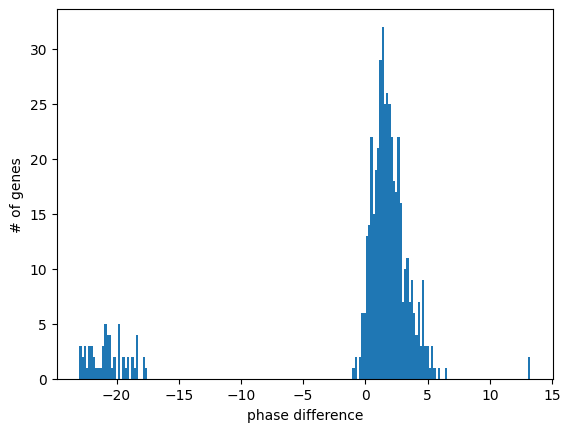

In [29]:
# Subselect genes with lowest p_value, i.e. the most robustly rhythmic
gene_OI = df.sort_values(by=['pv_exon', 'pv_intron'], ascending = True)

## Keep several hundred genes  
gene_OI = gene_OI.head(500)

#Get phase relationship
phase_relationship = gene_OI['phase_exon'] - gene_OI['phase_intron']

#Plot histogram
plt.subplot(1, 1, 1)
plt.hist(phase_relationship, bins=200, label = 'exons')
plt.xlabel("phase difference")
plt.ylabel("# of genes")
plt.show()

#### Question2 (2)

In [30]:
phase_relationship

phase_relationship = phase_relationship.sort_values()

phase_relationship

Gene_Symbol
Pld1        -22.978873
Rnf125      -22.913321
Loxl4       -22.854069
Rnf144a     -22.729592
Avpr1a      -22.631758
               ...    
Anxa7         5.512612
Vps41         5.937826
Hist1h2bc     6.376795
Nlrp4a       13.254679
Cyp2b19      13.260356
Length: 500, dtype: float64

In [31]:
## Subselect samples of the full data based on feature, condition, replicate and time
def subselect(data, feature, time, replicate):
    f1 = data.columns.get_level_values('feature').isin(feature)
    f2 = data.columns.get_level_values('time').isin(time)
    f3 = data.columns.get_level_values('replicate').isin(replicate)
    dat_sub= data.iloc[:,f1 & f2 & f3]
    
    return dat_sub

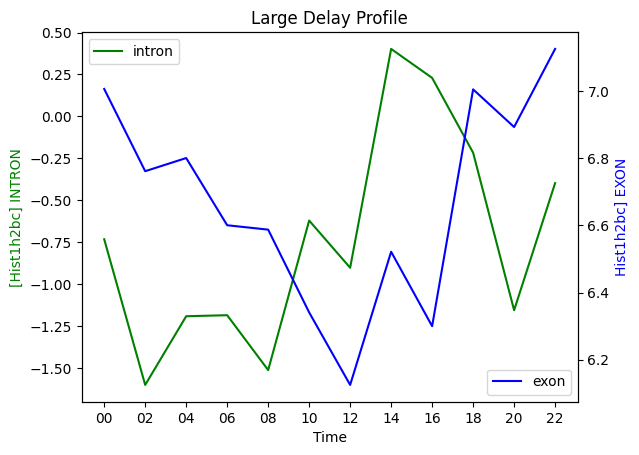

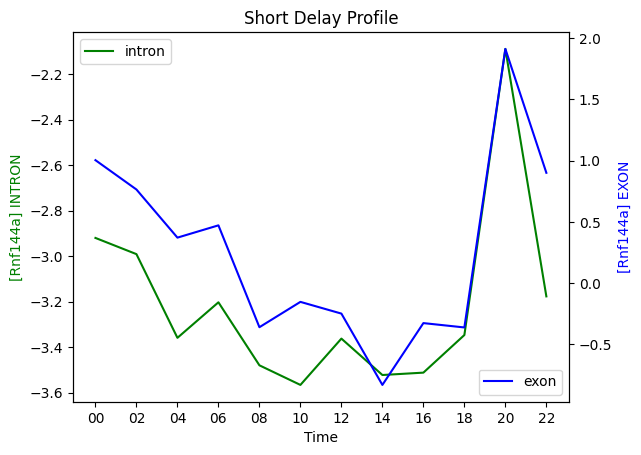

In [32]:
genes = ['Pld1', 'Anxa7', 'Rnf125', 'Cyp2b19', 'Nlrp4a', 'Hist1h2bc', 'Avpr1a', 'Rnf144a']
dat2 = dat[dat.index.isin(genes)]
dat2

#column_headers = list(data_delay.columns.values)
time = ['00','02','04','06','08','10','12','14','16','18','20','22']

data_intron = subselect(dat2,['Intron'],time, ['A'])
data_exon = subselect(dat2, ['Exon'],time, ['A'])

data_intron.columns = time
data_exon.columns = time

data_intron = data_intron.T
data_exon = data_exon.T

#Plot Large Delay Profile
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(data_intron['Hist1h2bc'], label="intron", color='g')
ax2.plot(data_exon['Hist1h2bc'],  label="exon", color='b')

ax1.set_xlabel('Time')
ax1.set_ylabel('[Hist1h2bc] INTRON', color='g')
ax2.set_ylabel('Hist1h2bc] EXON', color='b')
ax1.legend(loc=2)
ax2.legend(loc=4)

plt.title("Large Delay Profile")
plt.show()

#Plot Short Delay Profile
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(data_intron['Rnf144a'], label="intron", color='g')
ax2.plot(data_exon['Rnf144a'],  label="exon", color='b')

ax1.set_xlabel('Time')
ax1.set_ylabel('[Rnf144a] INTRON', color='g')
ax2.set_ylabel('[Rnf144a] EXON', color='b')
ax1.legend(loc=2)
ax2.legend(loc=4)

plt.title("Short Delay Profile")
plt.show()


#### Question2 (3)

In [16]:
is_gene = np.array([d in list(gene_rhy.index.values) for d in dat.index.values])
ii = np.arange(len(dat))[is_gene]

[    3   108   166   199   258   284   293   513   518   564   610   664
   681   708   849   937   998  1008  1017  1043  1082  1133  1201  1253
  1279  1365  1661  1779  1837  1839  1851  1864  1884  1888  1915  1921
  2102  2111  2190  2270  2285  2446  2514  2515  2616  2628  2665  2680
  2700  2705  2872  2919  2934  2939  3003  3049  3119  3209  3267  3285
  3415  3508  3525  3535  3596  3621  3669  3775  3802  3811  3813  3896
  3942  3948  4086  4092  4171  4176  4285  4328  4365  4420  4458  4465
  4474  4523  4596  4638  4677  4730  4732  4772  4917  5128  5131  5186
  5216  5232  5287  5385  5512  5514  5529  5598  5621  5627  5630  5692
  5724  5729  5750  6154  6205  6314  6358  6374  6468  6471  6908  6966
  7043  7157  7229  7253  7284  7285  7322  7333  7344  7529  7803  8011
  8038  8105  8123  8303  8319  8432  8471  8519  8634  8694  8733  8807
  8814  8874  8994  9067  9118  9179  9224  9227  9268  9277  9280  9381
  9435  9571  9821  9841  9873 10129 10156 10185 10

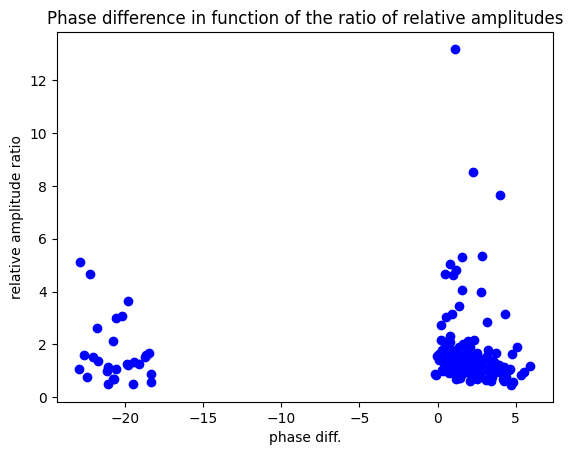

In [27]:
#Note that because you fitted the log2 data, the relative amplitudes take the form
relamp_exon = 2**amp_exon[ii] - 2**(-amp_exon[ii])
relamp_intron = 2**amp_intron[ii]- 2**(-amp_intron[ii])

relamp_ratio = relamp_exon/relamp_intron

phase_diff = phase_exon[ii] - phase_intron[ii]

#Plot Short Delay Profile
plt.subplots()

plt.scatter(phase_diff, relamp_ratio, color='b')

plt.ylabel('relative amplitude ratio')
plt.xlabel('phase diff.')

plt.title("Phase difference in function of the ratio of relative amplitudes")
plt.show()